# Serve Llama2-7b on SageMaker using the LMI container.


In this notebook, we deploy the [llama2-7B](https://huggingface.co/TheBloke/Llama-2-7b-fp16) model on SageMaker by leveraging the [SageMaker Large Model Inference Container](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers). For the purpose of this notebook, we'll use the weights from the following source:
- https://huggingface.co/TheBloke/Llama-2-7b-fp16
- https://huggingface.co/TheBloke/Llama-2-7B-Chat-fp16

However, you can use the same approach to deploy the model using any other Llama2 weights like https://huggingface.co/TheBloke/Llama-2-7B-Chat-fp16, etc.

For information on llama2, please refer the paper [Llama 2: Open Foundation and Fine-Tuned Chat Models](https://arxiv.org/pdf/2307.09288.pdf).

This notebook explains how to deploy model optimized for latency and throughput. The tuning guide is available [LLM Tuning Guide](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers). There are some key Gen Ai Patterns and use cases and they need different settings when hosting the model. The typical broad use case caterization would be 

1. Chatbot / QA applications which need the ability to handle large model inputs and large model outputs. With contextual applications these need prescritive and factual responses back from LLM which can be controlled by setting the appropriate decoding parameters. Latency and accuracy is top priority.
2. Summarization. These applications usually have a large payload as input to the model and will have a small to medium output length payload. If we run these as batch we have some tolerence on latency, however throughput is a major concern. 
3. Generation. These applications usually have a smaller input payload but the open ended generation can involve generating to the full content length of the model. Throughput is of major concern along with Latency.

# License agreement
 - View license information https://huggingface.co/meta-llama before using the model.
 - This notebook is a sample notebook and not intended for production use. Please refer to the licence at https://github.com/aws/mit-0. 

## Install, import the required libraries; set some variables

In [5]:
!pip install sagemaker boto3 huggingface_hub awscli --upgrade --quiet

In [6]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import os
import time
import json
from pathlib import Path

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [7]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

In [8]:
model_bucket = sess.default_bucket()  # bucket to house model artifacts
s3_code_prefix = "hf-large-model-djl/meta-llama/Llama-2-7b-fp16/code"  # folder within bucket where code artifact will go

s3_model_prefix = "hf-large-model-djl/meta-llama/Llama-2-7b-fp16/model"  # folder within bucket where model artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

### Select the appropriate configuration parameters and container¶

To optimize the deployment of Large Language Models (LLMs); one needs to choose the appropriate model partitioning framework, optimal batching technique, batching size, tensor parallelism degree, etc. The choice of a particular configuration depends on the usecase.

Hence, based on the usecase, you need to:
1. set the configuration parameters for the container.
2. select the appropriate container image to be used for inference.

## Usecase: Open Ended generation - Chatbots, etc
Consider the following scenarios - 
- prompts with small input size and a small generated text
- prompts with a small input size that generate a large number of tokens

Applications like chatbots, etc have the above characteristics and also need to support a high throughput. This needs to be taken into consideration while selecting the configuration parameters.

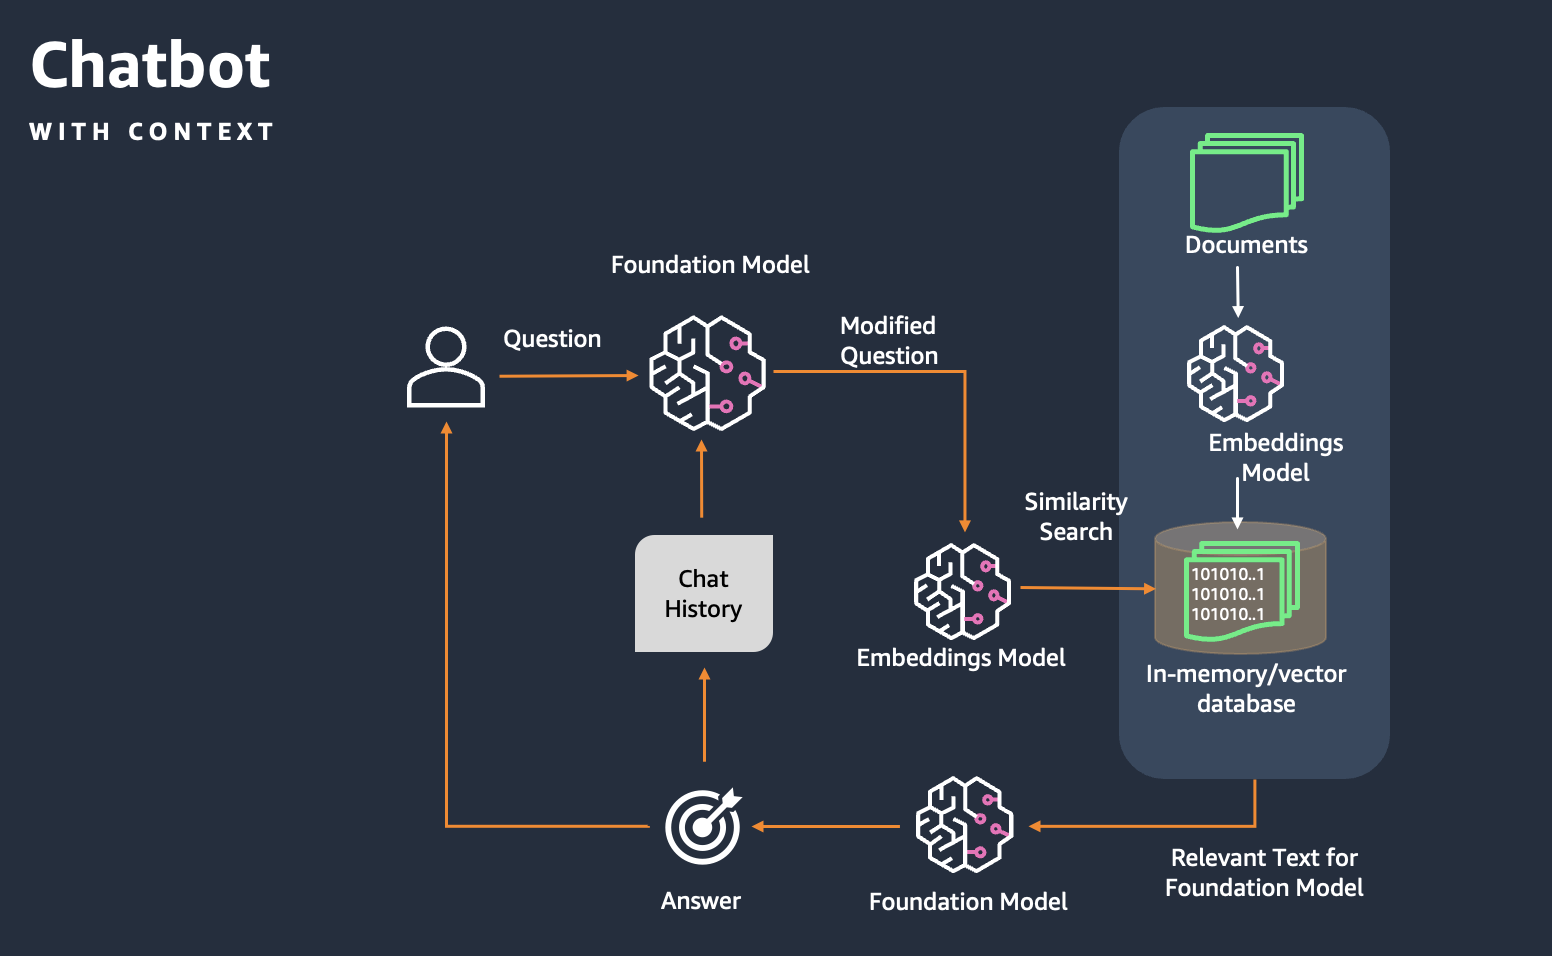

### Set the configuration parameters using environment variables
1. `SERVING_LOAD_MODELS` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the **Python** engine.

2. `OPTION_MODEL_ID`: Set this to the URI of the Amazon S3 bucket that contains the model. When this is set, the container leverages [s5cmd](https://github.com/peak/s5cmd) to download the model from s3. This enables faster deployments by utilizing optimized approach within the DJL inference container to transfer the model from S3 into the hosting instance.
If you want to download the model from huggingface.co, you can set `OPTION_MODEL_ID` to the model id of a pre-trained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co.

3. `OPTION_TENSOR_PARALLEL_DEGREE`: Set to the number of GPU devices over which DeepSpeed needs to partition the model. This parameter also controls the number of workers per model which will be started up when DJL serving runs. In this example we use the `ml.g5.12xlarge` instance that has 4 GPUs; hence this is set to 4.

4. `OPTION_ROLLING_BATCH`: This parameter enables the use of a particular batching technique for continuous or iteration level batching to enable merging multiple concurrent requests that arrive at different times for inference.
In scenarios that involves open ended generation and chatbots, there is a need for having a high throughput. [vLLM](https://arxiv.org/pdf/2309.06180.pdf) is a fast LLM inference and serving framework that uses techniques like PagedAttention and continuous batching to improve the throughput. Hence, we set the `rolling_batch` parameter to `vllm`. When using `vllm`, you can also use some [additional parameters](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md#vllm).

5. `OPTION_MAX_ROLLING_BATCH_SIZE`: The maximum number of concurrent requests to be used in a batch by the model server for inference. Clients can still send more requests to the endpoint, they will be queued.


For more information on the available options, please refer to the [DJL Serving - SageMaker Large Model Inference Configurations](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md)


### Select the relevant Large Model Inference container
SageMaker offers optimized [large model inference containers](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers) that contains different frameworks for model parallelism enabling inference of LLMs on multiple GPUs.

In this scenario, since we are leveraging `vllm` as the batching technique, we leverage the `deepspeed` container that has frameworks like deepspeed, vllm, etc.

In [22]:
deepspeed_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", 
    region=sess.boto_session.region_name, 
    version="0.26.0"
)

env_generation = {"HUGGINGFACE_HUB_CACHE": "/tmp",
                  "TRANSFORMERS_CACHE": "/tmp",
                  "SERVING_LOAD_MODELS": "test::Python=/opt/ml/model",
                  "OPTION_MODEL_ID": "TheBloke/Llama-2-7B-Chat-fp16",
                  "OPTION_TRUST_REMOTE_CODE": "true",
                  "OPTION_TENSOR_PARALLEL_DEGREE": "max",
                  "OPTION_ROLLING_BATCH": "vllm",
                  "OPTION_MAX_ROLLING_BATCH_SIZE": "32",
                  "OPTION_DTYPE":"fp16"
                 }

## Usecase: Summarization

This use-case is characterized by prompts that have a high number of tokens and generated output that has a lower number of tokens.

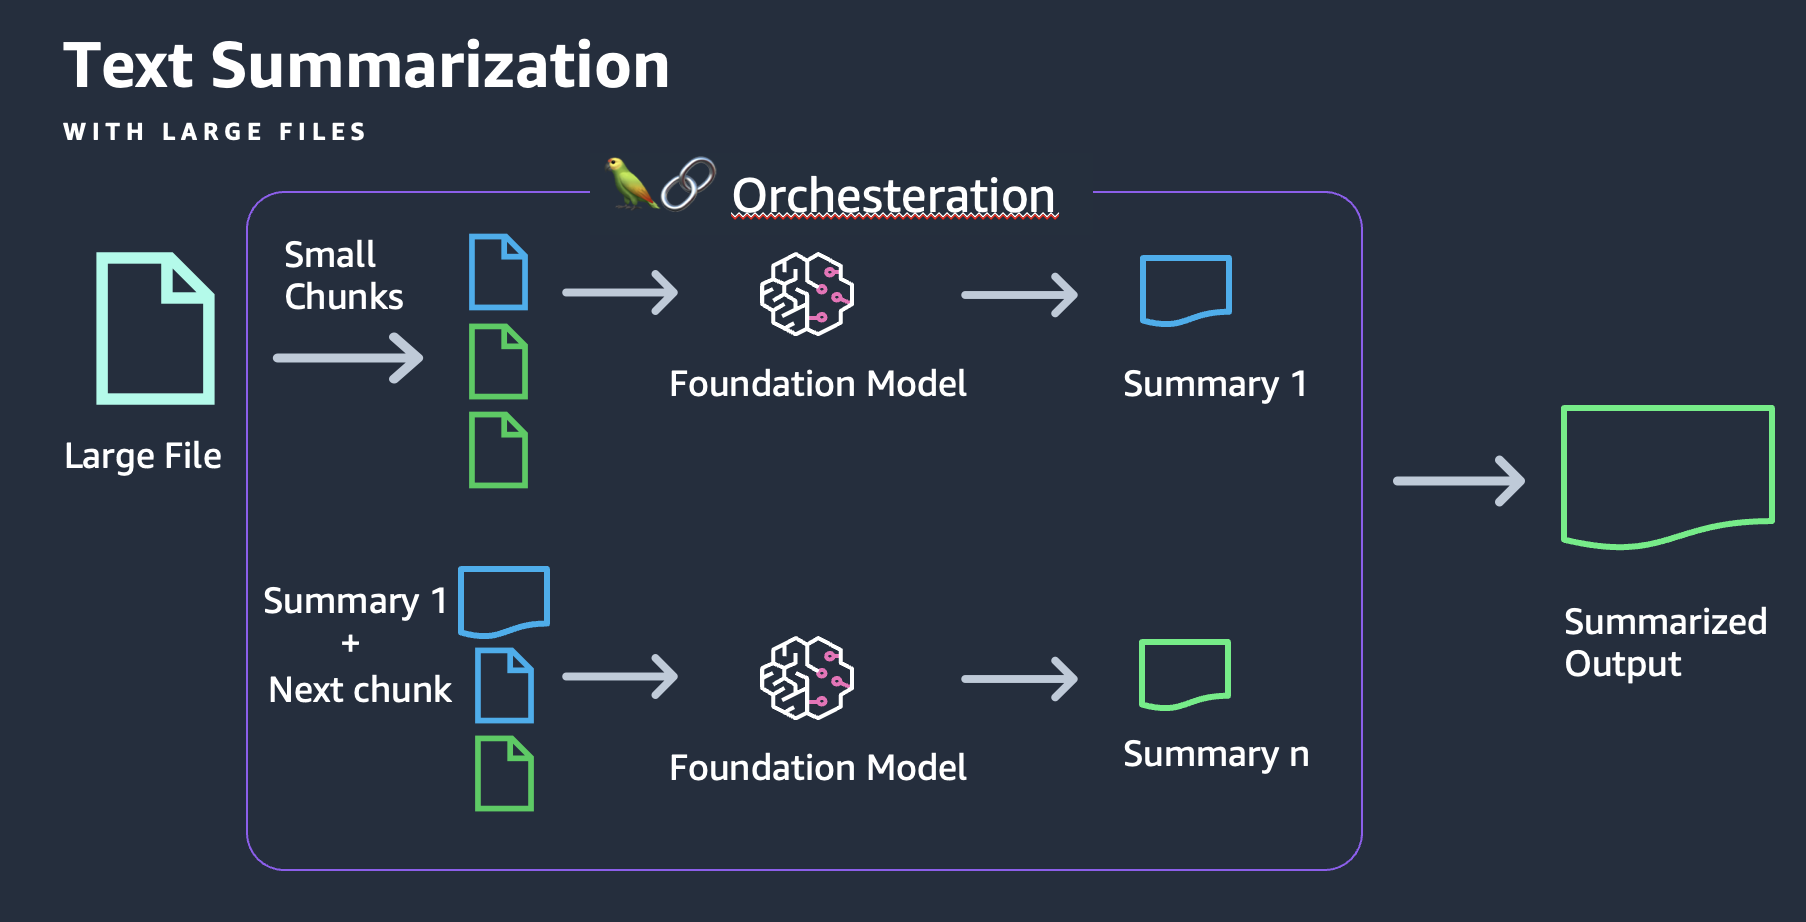

### Set the configuration parameters using environment variables
1. `SERVING_LOAD_MODELS` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the **MPI**. **MPI** is an engine that allows the model server to start distributed processes to load and serve the model.

2. `OPTION_ROLLING_BATCH`: This parameter enables the use of a particular batching technique for continuous or iteration level batching to enable merging multiple concurrent requests that arrive at different times for inference. [TensorRT-LLM](https://github.com/NVIDIA/TensorRT-LLM) is a TensorRT Toolbox for Optimized Large Language Model Inference on Nvidia GPUs. To leverage this, we set this parameter to `trtllm`. 
 

For more information on the available options, please refer to the [DJL Serving - SageMaker Large Model Inference Configurations](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md)


### Select the relevant Large Model Inference container
SageMaker offers optimized [large model inference containers](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers) that contains different frameworks for model parallelism enabling inference of LLMs on multiple GPUs.

In this scenario, since we are leveraging `trtllm` as the batching technique, we leverage the `tensorrtllm` container that has the TensorRT-LLM framework.

In [23]:
trtllm_image_uri = image_uris.retrieve(
    framework="djl-tensorrtllm",
    region=sess.boto_session.region_name,
    version="0.26.0"
)


env_summarization = {"HUGGINGFACE_HUB_CACHE": "/tmp",
                     "TRANSFORMERS_CACHE": "/tmp",
                     "SERVING_LOAD_MODELS": "test::MPI=/opt/ml/model",
                     "OPTION_MODEL_ID": "TheBloke/Llama-2-7b-fp16",
                     "OPTION_TENSOR_PARALLEL_DEGREE": "max",
                     "OPTION_ROLLING_BATCH": "trtllm",
                     "OPTION_MAX_ROLLING_BATCH_SIZE": "64"
                    }

### Select the appropriate inference image and configuration parameters depending on the use case.

For the purpose of the deployment we will select summarization. If you use case us Chatbot or QA please select the appropriate container and configuration as noted in the comments

In [24]:
# - Select the appropriate environment variable which will tune the deployment server.
env = env_generation # use this in case it is 'generation' task 
# env = env_summarization # enable this in case your use case is summarization ( high input and medium output sizes )

# - now we select the appropriate container 
inference_image_uri = deepspeed_image_uri # use this in case it is 'generation' task 
#inference_image_uri = trtllm_image_uri # enable this in case your use case is summarization ( high input and medium output sizes ) 


print(f"Environment variables are ---- > {env}")
print(f"Image going to be used is ---- > {inference_image_uri}")

Environment variables are ---- > {'HUGGINGFACE_HUB_CACHE': '/tmp', 'TRANSFORMERS_CACHE': '/tmp', 'SERVING_LOAD_MODELS': 'test::Python=/opt/ml/model', 'OPTION_MODEL_ID': 'TheBloke/Llama-2-7B-Chat-fp16', 'OPTION_TRUST_REMOTE_CODE': 'true', 'OPTION_TENSOR_PARALLEL_DEGREE': 'max', 'OPTION_ROLLING_BATCH': 'vllm', 'OPTION_MAX_ROLLING_BATCH_SIZE': '32', 'OPTION_DTYPE': 'fp16'}
Image going to be used is ---- > 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.26.0-deepspeed0.12.6-cu121


To create the end point the steps are:
- Create the Model using the inference image container

- Create the endpoint config using the following key parameters

In this notebook we leverage the boto3 SDK. You can also use the [SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/).

### Create the Model
Leverage the `inference_image_uri` to create a model object. We will leverage the Least routing algorithim -- [Least Routing Algorithim](https://aws.amazon.com/blogs/machine-learning/minimize-real-time-inference-latency-by-using-amazon-sagemaker-routing-strategies/). This innovation from sagemnaker has shown to reduce latency by 10% or more when we have multiple instances configured to serve the endpoints

In [25]:
model_name = sagemaker.utils.name_from_base("lmi-llama2-7b")
print(model_name)

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "Environment": env,
    }
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

lmi-llama2-7b-2024-03-05-21-02-32-542
Created Model: arn:aws:sagemaker:us-east-1:757967535041:model/lmi-llama2-7b-2024-03-05-21-02-32-542


### Create an endpoint config
Create an endpoint configuration using the appropriate instance type. Set the `ContainerStartupHealthCheckTimeoutInSeconds` to account for the time taken to download the LLM weights from S3 or the model hub; and the time taken to load the model on the GPUs.

In [26]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g5.2xlarge",
            "InitialInstanceCount": 1,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 2400,
            "RoutingConfig": {
                'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'
            },
        },
    ],
)
endpoint_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:757967535041:endpoint-config/lmi-llama2-7b-2024-03-05-21-02-32-542-config',
 'ResponseMetadata': {'RequestId': 'dee99473-36e6-4328-88d5-3eab05ebd575',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'dee99473-36e6-4328-88d5-3eab05ebd575',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '125',
   'date': 'Tue, 05 Mar 2024 21:02:34 GMT'},
  'RetryAttempts': 0}}

### Create an endpoint using the model and endpoint config

In [27]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-east-1:757967535041:endpoint/lmi-llama2-7b-2024-03-05-21-02-32-542-endpoint


#### This step can take ~15 mins or longer

In [28]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:757967535041:endpoint/lmi-llama2-7b-2024-03-05-21-02-32-542-endpoint
Status: InService


### Invoke the endpoint with a sample prompt

In [29]:
# - use these for Summarization use case test 
prompt = """Briefly summarize this paragraph: Amazon Comprehend uses natural language processing (NLP) to extract insights about the content of documents. It develops insights by recognizing the entities, key phrases, language, sentiments, and other common elements in a document. Use Amazon Comprehend to create new products based on understanding the structure of documents. For example, using Amazon Comprehend you can search social networking feeds for mentions of products or scan an entire document repository for key phrases.
You can access Amazon Comprehend document analysis capabilities using the Amazon Comprehend console or using the Amazon Comprehend APIs. You can run real-time analysis for small workloads or you can start asynchronous analysis jobs for large document sets. You can use the pre-trained models that Amazon Comprehend provides, or you can train your own custom models for classification and entity recognition.
All of the Amazon Comprehend features accept UTF-8 text documents as the input. In addition, custom classification and custom entity recognition accept image files, PDF files, and Word files as input.
Amazon Comprehend can examine and analyze documents in a variety of languages, depending on the specific feature. For more information, see Languages supported in Amazon Comprehend. Amazon Comprehend’s Dominant language capability can examine documents and determine the dominant language for a far wider selection of languages."""
params = { "max_new_tokens":64, "temperature":0.1}

In [30]:
# use this for Chatbot or QA or open ended generation task
prompt = "Amazon.com is the best"
params = { "max_new_tokens": 100,"do_sample": False }

In [31]:
response_model = smr_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=json.dumps(
        {
            "inputs": prompt,
            "parameters": params
        }
    ),
    ContentType="application/json",
)

response_model["Body"].read().decode("utf8")

'{"generated_text": " online store for American and International customers, its vast selection, fast and reliable shipping, competitive pricing, excellent customer service, trustworthy sellers, amongst other things.\\nAnyone residing in the United States of America or any other part of the world with access to the internet can purchase from Amazon.com.\\nDue to its simple payment procedures, vast inventory, and fast delivery, Amazon has gained popularity among millions of consumers worldwide. Please provide more"}'

## Clean up the environment

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=model_name)

#### Resource:
- [Deep Learning containers for large model inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-dlc.html)
- [Deep Java Library for Large Model Inference](https://docs.djl.ai/docs/serving/serving/docs/large_model_inference.html)